# Intro

Neural style transfer is the problem of generating a new image which has the content from one image and the style(s) from another. It is ill-posed; for style transfer there is no single correct output. Also, we can't readily apply traditional supervised learning algorithms. It would require a pair of input images—both an original image and an artistic representation of that original image, which is not practical. 

### A Neural Algorithm of Artistic Style

Gatys et al. published one of the first seminal works to use neural networks to solve this problem. 
The most important idea here is "representations of content and style in the Convolutional Neural Network are separable". 
They use the following definitions to remove ambiguity from the ill-posed problem.

1. Two images are similar in content if their high-level features as extracted by a trained classifier are close in Euclidian distance.
2. Two images are similar in style if their low-level features as extracted by a trained classifier share the same statistics or, more concretely, if the difference between the features’ Gram matrices has a small Frobenius norm.

The objective function is the weighted sum of style and content distance. The minima of the objective function found using gradient descent corresponds to the desired stylized image.  


The algorithm does have a few limitations 
1. prohibitively expensive espectially for high resolution images - task is modelled as an optimization problem, requiring hundreds or thousands of iterations.   
2. haven't provided evidence for  multi-style transfer extns

Despite its flaws, the algorithm is very flexible. Therefore, I decided to first explore this method to solve the assignment.


##### Modified Algorithm

Given content image $\vec{p}$ and style image $\vec{a}$, the loss function to minimise was

$$\mathcal{L}_{\text {total }}(\vec{p}, \vec{a}, \vec{x})=\alpha \mathcal{L}_{\text {content }}(\vec{p}, \vec{x})+\beta \mathcal{L}_{\text {style }}(\vec{a}, \vec{x})$$

I just replace the the style loss with weighted loss terms corresponding to each style. 


$$\mathcal{L}_{\text {total }}(\vec{p}, \vec{a}, \vec{x})=\alpha \mathcal{L}_{\text {content }}(\vec{p}, \vec{x})+\sum_{i=1}^{N}\beta_i \mathcal{L}_{\text {style}_i}(\vec{a}_i, \vec{x})$$

##### Pretrained model VGG19

![VGG19](images/vgg19.png)

VGG19 pretrained on IMAGENET is used as a feature extractor. It consists of 9 layers, including 16 convolutional layers, 3 fully connected layers, 5 max-pooling layers, and 1 softmax layer. We are only concerned with features and not classification, so we safely remove the fully connected layers. The output of the individual convolution layers will be used to find the content and style losses. 
- The object information increasingly explicit along the processing hierarchy. Detailed pixel information is lost while the high-level content of the image is preserved. Therefore I could use the `conv_4` or `conv_5` filters for finding the content loss.
- The style representation is computed using the correlations between the different features in different layers of the model, where the expectation is taken over the spatial extend of the input image. The texture/style is the statistical relationship between the pixels of a
source image which is assumed to have a stationary distribution at some scale. Therefore we can use all the `conv` outputs to compute style loss.


##### Implementation

I found a relevant tutorial [Neural Transfer Using PyTorch](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html). I have made a few changes to it to make it applicable for multi-style. I haven't invested much effort here to write the code from scratch as I would like to demonstrate my skills later in a novel and more interesting task. 

# Algorithm

I 

# Implementation


In [4]:
import ast
import os
from skimage import io
import numpy as np
import tensorflow.compat.v1 as tf
from icecream import ic
import matplotlib.pyplot as plt

from image_stylization import image_utils, model, ops


def _load_checkpoint(sess, checkpoint):
    """Loads a checkpoint file into the session."""
    model_saver = tf.train.Saver(tf.global_variables())
    checkpoint = os.path.expanduser(checkpoint)
    if tf.gfile.IsDirectory(checkpoint):
        checkpoint = tf.train.latest_checkpoint(checkpoint)
        tf.logging.info("loading latest checkpoint file: {}".format(checkpoint))
    model_saver.restore(sess, checkpoint)


def _describe_style(which_styles):
    """Returns a string describing a linear combination of styles."""

    def _format(v):
        formatted = str(int(round(v * 1000.0)))
        while len(formatted) < 3:
            formatted = "0" + formatted
        return formatted

    values = []
    for k in sorted(which_styles.keys()):
        values.append("%s_%s" % (k, _format(which_styles[k])))
    return "_".join(values)


def _style_mixture(which_styles, num_styles):
    """Returns a 1-D array mapping style indexes to weights."""
    if not isinstance(which_styles, dict):
        raise ValueError("Style mixture must be a dictionary.")
    mixture = np.zeros([num_styles], dtype=np.float32)
    for index in which_styles:
        mixture[index] = which_styles[index]
    return mixture



def _multiple_styles(input_image, which_styles, output_dir, checkpoint, output_basename, num_styles=10, alpha=1.0):
    """Stylizes image into a linear combination of styles and writes to disk."""
    with tf.Graph().as_default(), tf.Session() as sess:
        mixture = _style_mixture(which_styles, num_styles)
        stylized_images = model.transform(
            input_image,
            alpha=alpha,
            normalizer_fn=ops.weighted_instance_norm,
            normalizer_params={
                "weights": tf.constant(mixture),
                "num_categories": num_styles,
                "center": True,
                "scale": True,
            },
        )
        _load_checkpoint(sess, checkpoint)

        stylized_image = stylized_images.eval()

        image = np.uint8(stylized_image * 255.0)
        plt.imshow(np.squeeze(image, 0), interpolation='nearest')

            
        image_utils.save_np_image(
            stylized_image,
            os.path.join(
                output_dir,
                "%s_%s.png" % (output_basename, _describe_style(which_styles)),
            ),
        )

tf.disable_v2_behavior()
input_image = "images/dancing.jpg"
checkpoint = "image_stylization/multistyle-pastiche-generator-monet.ckpt"
output_basename = "all_monet_styles"
output_dir = "output"
image = np.expand_dims(
    image_utils.load_np_image(os.path.expanduser(input_image)), 0
)

output_dir = os.path.expanduser(output_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

which_styles =  {0: 0.1, 1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1, 5: 0.1, 6: 0.1, 7: 0.1, 8: 0.1, 9: 0.1}
_multiple_styles(image, which_styles, output_dir, checkpoint, output_basename)


ModuleNotFoundError: No module named 'skimage'

In [ ]:
python -m image_stylization.image_stylization_transform \
      --num_styles=10 \
      --checkpoint=image_stylization/multistyle-pastiche-generator-monet.ckpt \
      --input_image=images/dancing.jpg \
      --which_styles="{0:0.1,1:0.1,2:0.1,3:0.1,4:0.1,5:0.1,6:0.1,7:0.1,8:0.1,9:0.1}" \
      --output_dir=output \
      --output_basename="all_monet_styles"

sh jp.sh 8998 1234 10.2.40.75 a

sh jp.sh 8998 1234 10.1.36.133 a
jupyter server list

python -m image_stylization.image_stylization_transform \
      --num_styles=32 \
      --checkpoint=image_stylization/multistyle-pastiche-generator-varied.ckpt \
      --input_image=images/dancing.jpg \
      --which_styles="{0: 0.02, 1: 0.03, 2: 0.02, 3: 0.0, 4: 0.06, 5: 0.03, 6: 0.06, 7: 0.01, 8: 0.0, 9: 0.03, 10: 0.04, 11: 0.05, 12: 0.01, 13: 0.03, 14: 0.0, 15: 0.01, 16: 0.04, 17: 0.04, 18: 0.04, 19: 0.06, 20: 0.03, 21: 0.04, 22: 0.06, 23: 0.02, 24: 0.03, 25: 0.02, 26: 0.02, 27: 0.01, 28: 0.0, 29: 0.06, 30: 0.05, 31: 0.04}" \
      --output_dir=output \
      --output_basename="all_monet_styles"


In [3]:
import numpy as np


def create_style(n=10):
    distrib = np.random.rand(n)
    distrib = distrib / np.sum(distrib)
    styles = {}
    for i in range(n):
        styles[i] = round(distrib[i], 2)
    return styles

styles = create_style(32)
# print in one line
print(styles)

{0: 0.02, 1: 0.03, 2: 0.02, 3: 0.0, 4: 0.06, 5: 0.03, 6: 0.06, 7: 0.01, 8: 0.0, 9: 0.03, 10: 0.04, 11: 0.05, 12: 0.01, 13: 0.03, 14: 0.0, 15: 0.01, 16: 0.04, 17: 0.04, 18: 0.04, 19: 0.06, 20: 0.03, 21: 0.04, 22: 0.06, 23: 0.02, 24: 0.03, 25: 0.02, 26: 0.02, 27: 0.01, 28: 0.0, 29: 0.06, 30: 0.05, 31: 0.04}


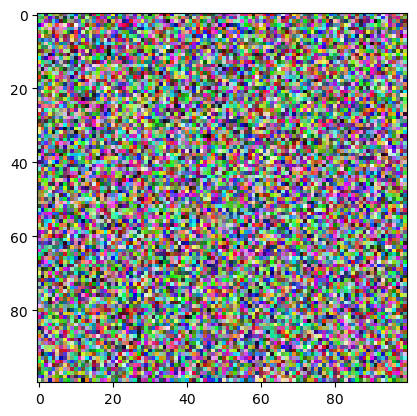

In [11]:
image = np.random.rand(100, 100, 3)

plt.imshow(image, interpolation='nearest')
